<h1><center>EE778: Optimal control</center></h1>
<h2><center>Optimal control of 2D undulating motion</center></h2>

## Introduction
Surge-cast is one of the most prominent reactive behavior of insect odor response. It is characterized by straight upwind motion with odor encounter, followed by side-to-side casting motion in the absence of odor. In 2D this motion can be modeled as undulating motion, where an agent has an oscillatory motion in the lateral direction along with the forward motion. Undulating motion is also observed in other biological systems such as fish swimming, snake locomotion etc. For the project required for this class, we will consider a simplified model of undulating motion in 2D. 

## Python Initialization
### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as sym
import pandas as pd

from sympy import symbols, Eq, solve, simplify, MatrixSymbol
from pprint import pprint
from IPython.display import display, Math, Markdown

from functions import *

%load_ext autoreload
%autoreload 2

### variables and constants

In [2]:
sym_x1, sym_x2, sym_y1, sym_y2, sym_theta1, sym_theta2, sym_theta3 = symbols('x1 x2 y1 y2 theta1 theta2 theta3')
sym_F, sym_tau = symbols('F tau')
sym_lmda1, sym_lmda2, sym_lmda3, sym_lmda4, sym_lmda5, sym_lmda6, sym_lmda7 = symbols('lambda1 lambda2 lambda3 lambda4 lambda5 lambda6 lambda7')

sym_states = sym.Matrix([sym_x1, sym_x2, sym_y1, sym_y2, sym_theta1, sym_theta2, sym_theta3])
sym_inputs = sym.Matrix([sym_F, sym_tau])
sym_lmdas = sym.Matrix([sym_lmda1, sym_lmda2, sym_lmda3, sym_lmda4, sym_lmda5, sym_lmda6, sym_lmda7])


## Model
The model assumes a point mass agent moving in 2D space with two control inputs: force in the forward direction and torque to change the heading angle. 

states: $\vec{x} = [x_2, x_1, y_2, y_1, \theta_3, \theta_2, \theta_1]^T\\$ where, $x_2, y_2$ are the second derivatives of the position in x and y directions, $\theta_2$ is the heading angle at any time instant. 

dynamic equations:
$$
\begin{align*}
\dot{x}_2 &= -c_1 x_2 + F \cos(\theta_2 + \theta_1)\\
\dot{x}_1 &= x_2\\
\dot{y}_2 &= -c_2 y_2 + F \sin(\theta_2 + \theta_1)\\
\dot{y}_1 &= y_2\\
\dot{\theta}_3 &= -c_3 \theta_3 - c_4 \theta_2 + \tau\\
\dot{\theta}_2 &= \theta_3\\
\dot{\theta}_1 &= \theta_2\\
\end{align*}
$$
where, $c_1, c_2, c_3, c_4$ are constants, $F$ is the force in the forward direction, $\tau$ is the torque to change the heading angle. The system is nonlinear where $\theta_1, \theta_2$ are not small angles. 

## Sample responses

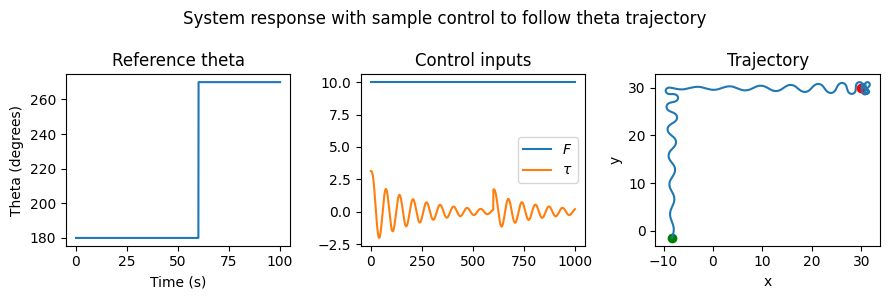

Here, the agent first moves towards the negative x-axis (ref $\theta$ = 180) and then towards the negative y-axis (ref $\theta$ = 270) from an initial direction of 0 degrees. The agent starts at the red point and ends at the green point.

In [3]:
T = 100
dt = .1
N = int(T/dt)
timeseries = np.linspace(0, T, N)

ref_theta = np.linspace(np.pi, np.pi * 1.5, N)
ref_theta = np.where(ref_theta > 1.3 * np.pi, 1.5 * np.pi, np.pi)

initial_state = [0, 30, 0, 30, 0, 0, 0]
result = sp.integrate.odeint(follow_sample_theta_trajectory, initial_state, timeseries, args=(timeseries, ref_theta))
xpos, ypos, = result[:,1], result[:,3]

inputs = [sample_control(result[i], timeseries[i], timeseries, ref_theta) for i in range(len(result))]
inputs = np.array(inputs)

fig, [ax,bx,cx] = plt.subplots(1,3, figsize=(9,3))
ax.plot(timeseries, np.rad2deg(ref_theta))
ax.set_title('Reference theta')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Theta (degrees)')
bx.plot(inputs, label=['$F$', '$\\tau$'])
bx.set_title('Control inputs')
bx.legend()
cx.plot(xpos, ypos)
cx.scatter(xpos[0], ypos[0], c='r')
cx.scatter(xpos[-1], ypos[-1], c='g')
cx.set_xlabel('x')
cx.set_ylabel('y')
cx.set_title('Trajectory')
fig.suptitle('System response with sample control to follow theta trajectory')
fig.tight_layout()
plt.show()

Markdown(f'''Here, the agent first moves towards the negative x-axis (ref $\\theta$ = 180) and then towards the negative y-axis (ref $\\theta$ = 270) from an initial direction of 0 degrees. The agent starts at the red point and ends at the green point.''')

# optimal control 

In [13]:
T = 100
dt = .1
N = int(T/dt)
timeseries = np.linspace(0, T, N)
c1 = 10
c2 = 10
c3 = 1.2
c4 = 1

sym_state_dot1 = -c1 * sym_x1 + sym_F * sym.cos(sym_theta1 + sym_theta2)
sym_state_dot2 = sym_x2
sym_state_dot3 = -c2 * sym_y1 + sym_F * sym.sin(sym_theta1 + sym_theta2)
sym_state_dot4 = sym_y2
sym_state_dot5 = -c3 * sym_theta3 - c4 * sym_theta2 + sym_tau
sym_state_dot6 = sym_theta3
sym_state_dot7 = sym_theta2

sym_f = sym.Matrix([sym_state_dot1, sym_state_dot2, sym_state_dot3, sym_state_dot4, sym_state_dot5, sym_state_dot6, sym_state_dot7])


# minimum time cost function
L = sym_inputs.dot(sym_inputs)
J = sym.Sum(L, (sym.Symbol('t'), 0, T))
print("cost function, J:")
display(J)

Hamiltonian = L + sym_lmdas.dot(sym_f)
print("Hamiltonian:")
display(Hamiltonian)

lmda_dot = -sym.diff(Hamiltonian, sym_states)
print("lambda_dot = -dH/dx:")
display(lmda_dot)

optimal_u = sym.diff(Hamiltonian, sym_inputs)
print("dH/du = 0:")
display(optimal_u)

sym_t, sym_s = symbols('t s')
# aa = sym.laplace_transform(lmda_dot, sym_t, sym_s, noconds=True)
# display(aa)
# sym.inverse_laplace_transform(aa, sym_s, sym_t, noconds=True)


cost function, J:


Sum(F**2 + tau**2, (t, 0, 100))

Hamiltonian:


F**2 + lambda1*(F*cos(theta1 + theta2) - 10*x1) + lambda2*x2 + lambda3*(F*sin(theta1 + theta2) - 10*y1) + lambda4*y2 + lambda5*(tau - theta2 - 1.2*theta3) + lambda6*theta3 + lambda7*theta2 + tau**2

lambda_dot = -dH/dx:


Matrix([
[                                                                         10*lambda1],
[                                                                           -lambda2],
[                                                                         10*lambda3],
[                                                                           -lambda4],
[                    F*lambda1*sin(theta1 + theta2) - F*lambda3*cos(theta1 + theta2)],
[F*lambda1*sin(theta1 + theta2) - F*lambda3*cos(theta1 + theta2) + lambda5 - lambda7],
[                                                              1.2*lambda5 - lambda6]])

dH/du = 0:


Matrix([
[2*F + lambda1*cos(theta1 + theta2) + lambda3*sin(theta1 + theta2)],
[                                                  lambda5 + 2*tau]])

In [15]:
lmda_func = sym.Function('lambda')(sym_t)
lmda_t = []

for i in range(7):
    cc = lmda_dot[i].subs(sym_lmdas[i], lmda_func) - lmda_func.diff(sym_t)
    result = sym.dsolve(cc)
    lmda_t.append(result.rhs.subs({sym.Symbol('C1'): sym.Symbol(f'C{i+1}')}))
    
lmda_t = sym.Matrix(lmda_t)
print("lambda(t):")
display(lmda_t)

lambda(t):


Matrix([
[                                                                                    C1*exp(10*t)],
[                                                                                      C2*exp(-t)],
[                                                                                    C3*exp(10*t)],
[                                                                                      C4*exp(-t)],
[                        C5 + F*lambda1*t*sin(theta1 + theta2) - F*lambda3*t*cos(theta1 + theta2)],
[C6 + F*lambda1*t*sin(theta1 + theta2) - F*lambda3*t*cos(theta1 + theta2) + lambda5*t - lambda7*t],
[                                                                  C7 + 1.2*lambda5*t - lambda6*t]])